In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def load_dataset(filename, which_channels = ["0_8","0_20"], noise_reject_rate = 0.01):
    """
    Load DT5550W DAQ dataset (processing mode = "FULL")
    
    Inputs
    -------
    filename: str
        Filename path
    which_channels: list or "auto"
        If which_channels is list, read the sepcified channels
        If which_channels is "auto", find active channels 
    noise_reject_rate: float in [0,1]
        The percentage of events needed to be identified as active channels, required only when which_channels is "auto"
        
    Returns
    -------
    df: Pandas dataframe
    """
    cols_list = pd.read_csv(filename, nrows=0).columns.tolist()[0].split(sep=";")
    #metadata_name = cols_list[:10]+cols_list[int(len(cols_list)/2+2):int(len(cols_list)/2+8)]
    metadata_name = cols_list[:10]
    dtype_list = ["HIT_","CHARGE_", "COARSE_", "FINE_","RELATIVETIME_"]
    #dtype_list = ["HIT_","CHARGE_", "COARSE_", "FINE_",]
    if which_channels == "auto": #Auto find active channels
        ch_hit =[]
        for i in range(32):
            ch_hit.append("HIT_0_{0}".format(i))
            ch_hit.append("HIT_1_{0}".format(i))
        hit_df = pd.read_csv(filename, sep=';', error_bad_lines = False,warn_bad_lines=True, usecols=ch_hit).fillna(0).to_numpy()
        ch_list = np.argwhere(np.sum(hit_df, axis = 0) > noise_reject_rate*len(hit_df))
        which_channels = []
        for index in ch_list:
            if index >= 32:
                which_channels.append("1_{0}".format(index[0]-32))
            else:
                which_channels.append("0_{0}".format(index[0]))
    data_ch = []
    for channels in which_channels:
        for ch_name in dtype_list:
            data_ch.append(ch_name+channels)
    return pd.read_csv(filename, sep=';', error_bad_lines = False,warn_bad_lines=True, usecols=metadata_name+data_ch)


def find_alpha(df, channels = ['FINE_0_8', 'FINE_0_26']):
    """
    FInd the calibration parameters for channels
    
    Inputs
    -------
    df: Dict
        A dictionary from Pandas dataframe for DT5550W DAQ dataset

    channels: list
        Channels to calibrate
    
    Returns
    -------
    alpha: list
        calibration constent for channels
    """
    
    alpha = np.zeros(len(channels))
    for i,ch in enumerate(channels):
        mask = (np.array(df[ch]) > 5)& (np.array(df[ch]) < 1000) #remove fine time = 4, 1020 events
        print(np.min(np.array(df[ch])[mask]))
        print(np.max(np.array(df[ch])[mask]))
        alpha[i] = 25/(np.max(np.array(df[ch])[mask])-np.min(np.array(df[ch])[mask]))
    return alpha


/tmp/ipykernel_123867/1422771822.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  df = load_dataset(filename, which_channels = "auto", noise_reject_rate = 0.01).to_dict('list')
/tmp/ipykernel_123867/1422771822.py:6: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  df = load_dataset(filename, which_channels = "auto", noise_reject_rate = 0.01).to_dict('list')


135
976
288
973
[0.02972652 0.03649635]


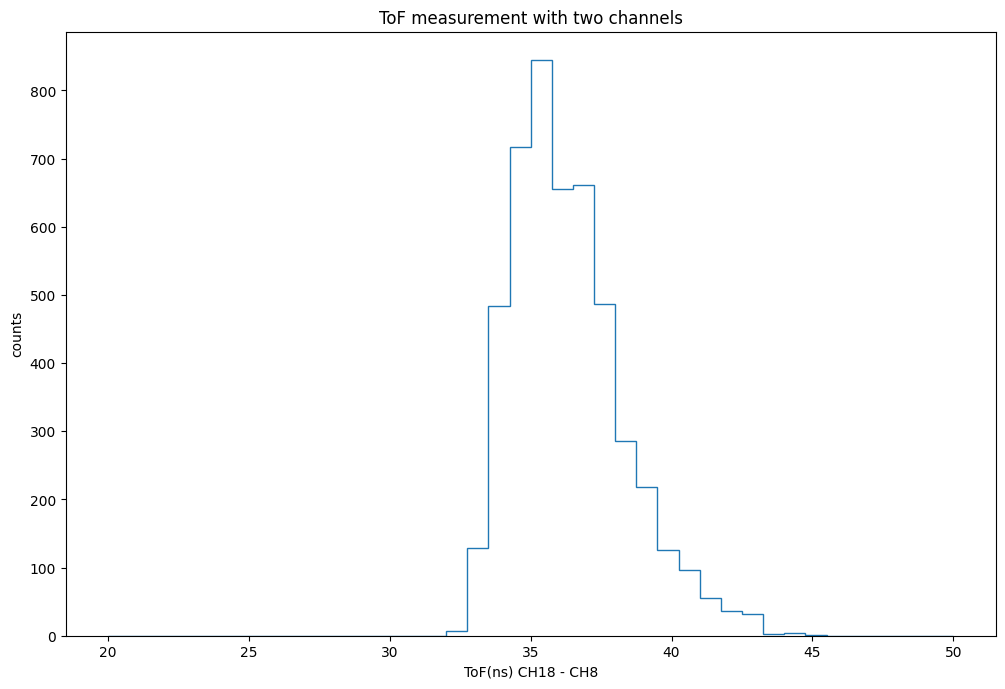

In [19]:
ch1 = 8
ch2 = 18


filename = "ToF/1202/1.data"
df = load_dataset(filename, which_channels = "auto", noise_reject_rate = 0.01).to_dict('list')

#remove fine time = 4, 1020 events
mask = ((np.array(df['FINE_0_{0}'.format(ch1)]) > 4)&(np.array(df['FINE_0_{0}'.format(ch1)]) < 1020)&
        (np.array(df['FINE_0_{0}'.format(ch2)]) > 4)&(np.array(df['FINE_0_{0}'.format(ch2)]) < 1020)) 

alpha = find_alpha(df, channels = ['FINE_0_{0}'.format(ch1), 'FINE_0_{0}'.format(ch2)])
fine_time = np.multiply(alpha,np.array([df['FINE_0_{0}'.format(ch1)]-np.min(np.array(df['FINE_0_{0}'.format(ch1)])[mask]),
                                        df['FINE_0_{0}'.format(ch2)]-np.min(np.array(df['FINE_0_{0}'.format(ch2)])[mask])]).T)

print(alpha)
#print(fine_time)
coarse_time = np.array([df['COARSE_0_{0}'.format(ch1)],df['COARSE_0_{0}'.format(ch2)]])*25

time = (coarse_time-fine_time.T)
ToF = time[0]-time[1]

plt.figure(figsize=(12, 8), dpi=100)

# plt.hist(fine_time.T[1],bins = 400, range = (-1,26), histtype = "step")
# plt.xlabel("Fine time(ns) CH8")
# plt.ylabel("counts")
# plt.title("Fine time of one channel")

# plt.hist2d(ToF, fine_time.T[0] ,bins=(200,50), range=[[-50,50],[-1,26]])
# plt.xlabel("ToF(ns) CH8 - CH18")
# plt.ylabel("Fine time(ns) CH18")

plt.hist(ToF,bins = 40, range = (20,50), histtype = "step", label = "binsize = 40")
plt.xlabel("ToF(ns) CH18 - CH8")
plt.ylabel("counts")
plt.title("ToF measurement with two channels")

plt.show()

In [16]:
25/0.03649635

685.0000068500001

Text(0.5, 1.0, 'Fine time')

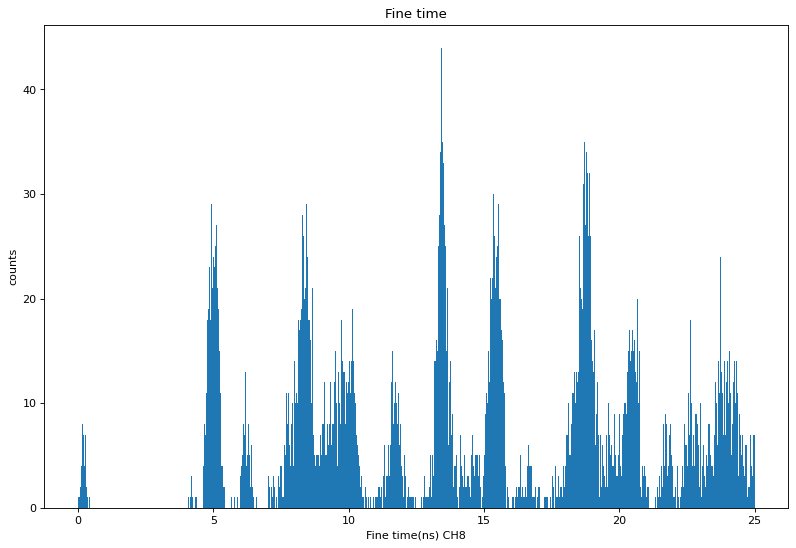

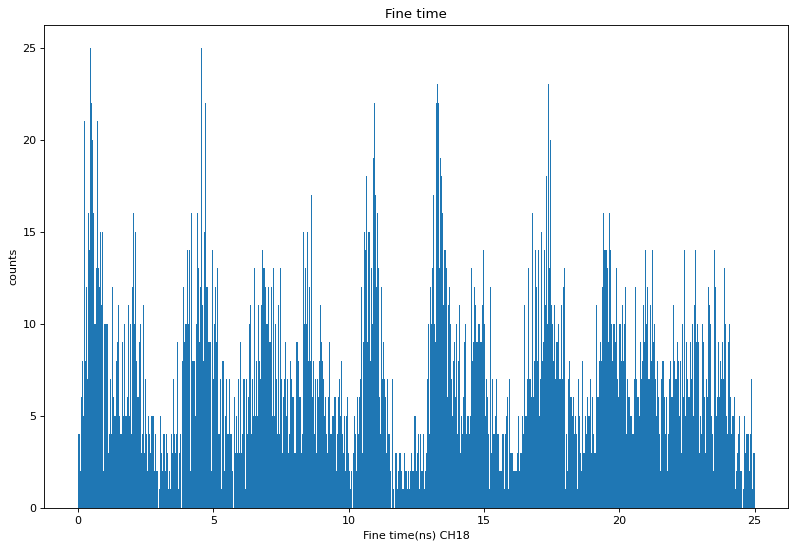

In [20]:
plt.figure(figsize=(12, 8), dpi=80)

plt.hist(fine_time.T[0],bins = 841, range = (0,25))
plt.xlabel("Fine time(ns) CH8")
plt.ylabel("counts")
plt.title("Fine time")

plt.figure(figsize=(12, 8), dpi=80)

plt.hist(fine_time.T[1],bins = 685, range = (0,25))
plt.xlabel("Fine time(ns) CH18")
plt.ylabel("counts")
plt.title("Fine time")